In [255]:
import math
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt 

from datetime import datetime
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
plt.style.use('fast')

In [256]:
icici = pdr.DataReader('ICICIBANK.BO', data_source='yahoo', start='2015-10-23', end='2019-12-30')

In [257]:
icici.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1027 entries, 2015-10-23 to 2019-12-30
Data columns (total 6 columns):
High         1027 non-null float64
Low          1027 non-null float64
Open         1027 non-null float64
Close        1027 non-null float64
Volume       1027 non-null float64
Adj Close    1027 non-null float64
dtypes: float64(6)
memory usage: 56.2 KB


In [258]:
icici.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-10-23,262.726990,259.000000,259.091003,260.135986,389855.0,245.185211
2015-10-26,263.364014,258.000000,261.817993,259.273010,336472.0,244.371811
2015-10-27,259.908997,256.635986,258.817993,257.908997,236226.0,243.086166
2015-10-28,254.727005,244.863998,254.544998,246.817993,823599.0,232.632614
2015-10-29,249.272995,245.727005,248.091003,246.772995,410657.0,232.590195


In [259]:
# we shall use the adjusted close because it takes into account all the 
# activites that have happened after the market closes
# such as any announcements the company made or any dividends
# it announced.

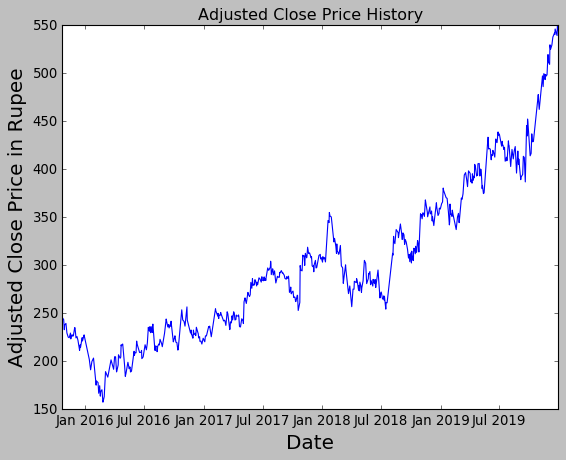

<Figure size 1600x800 with 0 Axes>

In [260]:
# visualize the adj. closing price history
plt.title('Adjusted Close Price History')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adjusted Close Price in Rupee', fontsize=18)
plt.plot(icici['Adj Close'])
plt.figure(figsize=(20,10))
plt.show()

In [261]:
#creating dataframe with only Adj Close
data = icici.filter(['Adj Close'])
#convert to numpy array
dataset = data.values
#using 10% of data to train and other 10% to test
training_data_len = math.floor(len(dataset)*0.9)

In [262]:
#normalizing the data is very important because LSTM is very sensisitive
#to the scale of the data
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)

In [263]:
#create the scaled training dataset
data_for_training = scaled_data[0:training_data_len]

#split into train and test dataset
x_train, y_train = [], []

for i in range(0,len(data_for_training)-60):
    x_train.append(data_for_training[i:i+60,0])
    y_train.append(data_for_training[i+60,0])


In [264]:
#convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train),np.array(y_train)

In [265]:
#reshape as LSTM needs 3D input 
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))


In [266]:
x_train.shape

(864, 60, 1)

In [293]:
#building stacked LSTM model
model = Sequential()
model.add(LSTM(70, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.1))
model.add(LSTM(70,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(70))
model.add(Dense(1))

In [294]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 60, 70)            20160     
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 70)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 60, 70)            39480     
_________________________________________________________________
dropout_14 (Dropout)         (None, 60, 70)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 70)                39480     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 71        
Total params: 99,191
Trainable params: 99,191
Non-trainable params: 0
__________________________________________________

In [295]:
#compiling the model
model.compile(optimizer = 'adam',loss='mean_absolute_error',metrics=['mean_absolute_error'])

In [296]:
#training the model
history = model.fit(x_train, y_train,epochs=50, batch_size = 50)

Epoch 1/50
864/864 [==============================] - 3s 4ms/step - loss: 0.1069 - mean_absolute_error: 0.1069
Epoch 2/50
864/864 [==============================] - 2s 2ms/step - loss: 0.0407 - mean_absolute_error: 0.0407
Epoch 3/50
864/864 [==============================] - 2s 2ms/step - loss: 0.0316 - mean_absolute_error: 0.0316
Epoch 4/50
864/864 [==============================] - 2s 2ms/step - loss: 0.0313 - mean_absolute_error: 0.0313
Epoch 5/50
864/864 [==============================] - 2s 2ms/step - loss: 0.0349 - mean_absolute_error: 0.0349
Epoch 6/50
864/864 [==============================] - 2s 2ms/step - loss: 0.0303 - mean_absolute_error: 0.0303
Epoch 7/50
864/864 [==============================] - 2s 2ms/step - loss: 0.0299 - mean_absolute_error: 0.0299
Epoch 8/50
864/864 [==============================] - 2s 2ms/step - loss: 0.0280 - mean_absolute_error: 0.0280
Epoch 9/50
864/864 [==============================] - 2s 2ms/step - loss: 0.0267 - mean_absolute_error: 0.0267
E

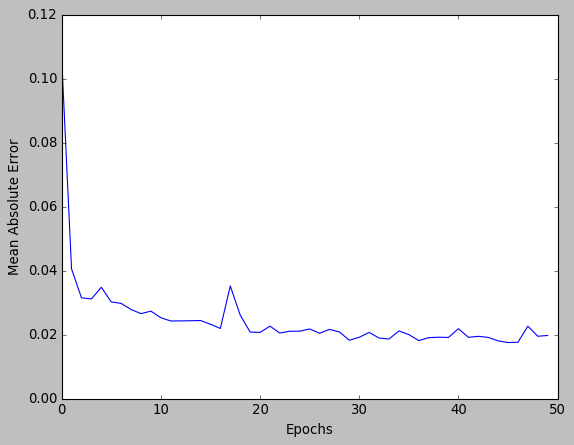

In [297]:
history_dict = history.history

plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.plot(history_dict['mean_absolute_error'])
plt.show()

In [298]:
len(scaled_data)

1027

In [299]:
training_data_len

924

In [300]:
# create the testing dataset
test_data = scaled_data[training_data_len-60: , :] # because x_test ended at the index training_data_len - 60


In [301]:
y_test = dataset[training_data_len:, :] # actual data


In [302]:
len(y_test)

103

In [303]:
x_test = []
for i in range(0,len(test_data)-60):
    x_test.append(test_data[i:i+60,0])

In [304]:
len(x_test)

103

In [305]:
x_test = np.array(x_test)

In [306]:
x_test.shape

(103, 60)

In [307]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [308]:
x_test.shape

(103, 60, 1)

In [309]:
predictions = model.predict(x_test)

In [310]:
predictions.shape

(103, 1)

In [311]:
y_test.shape

(103, 1)

In [312]:
predictions = scaler.inverse_transform(predictions)

In [313]:
mae = np.mean(np.abs(predictions-y_test))

In [314]:
mae

11.598715772906553

In [315]:
len(predictions)

103

In [316]:
math.sqrt(mean_squared_error(y_test,predictions))


13.570649060812665

/home/terminatorash2199/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


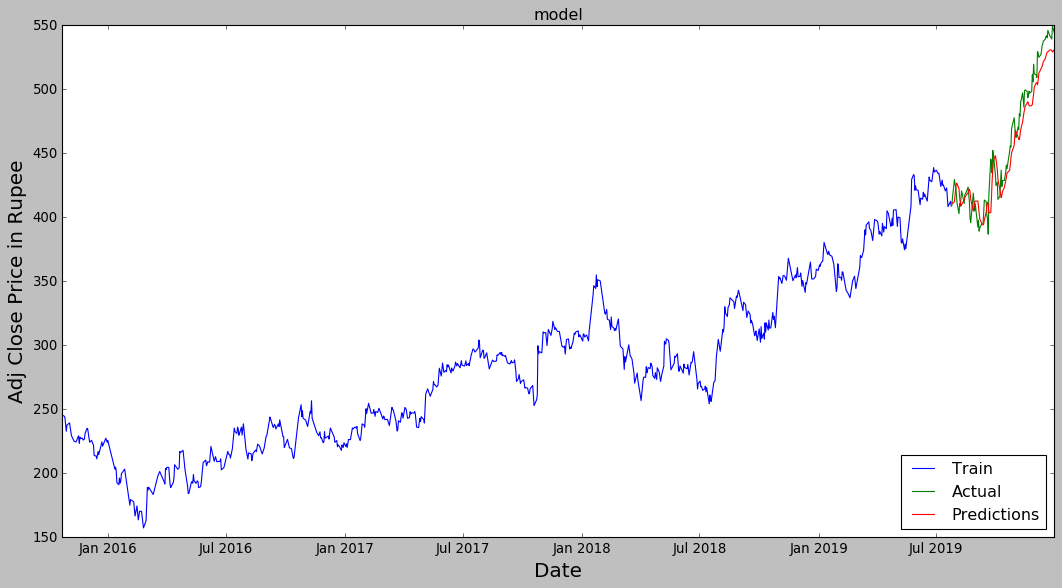

In [317]:
# plot the data
train = data[:training_data_len]
actual = data[training_data_len:]
actual['Predictions'] = predictions

# visualize the data
plt.figure(figsize=(16,8))
plt.title("model")
plt.xlabel('Date', fontsize =18)
plt.ylabel('Adj Close Price in Rupee', fontsize=18)

plt.plot(train['Adj Close'])
plt.plot(actual[['Adj Close','Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()

In [318]:
actual

,Adj Close,Predictions
Date,,
2019-07-25,409.049988,410.996887
2019-07-26,415.500000,410.489655
2019-07-29,429.299988,411.955536
2019-07-30,424.950012,417.495056
2019-07-31,424.500000,422.972076
2019-08-01,417.149994,426.440308
2019-08-02,410.750000,426.012970
2019-08-05,402.600006,422.015503
2019-08-06,410.399994,415.374847
